# 3 - Correlation and Pattern Prediction

## Data Mining Techniques in Comparison

In [1]:
import pandas as pd
import re 
import numpy as np
import seaborn as sn
import matplotlib.pyplot as plt

In [2]:
gem = pd.read_csv('task-and-exam-marks-in-groups.csv', delimiter=";", encoding="utf-8")
del gem["Unnamed: 0"]

In [3]:
pd.options.display.max_columns = 50

In [4]:
gem.head()

,tutor,team_id,b1,b2,b3,b4,b5,b6,b7,b8,b9,b10,b11,hash2,a1,a2,a3,a4,a5,a6,a7,punkte,note,student_id,pass,subject,semester,faculty,degree
0,tutor2,1.0,10.00,6.5,11.5,13.0,8.5,8.0,10.5,12.5,7.0,13.0,0.0,0afdc45f7ee8e52ebf1afb2970e37b36,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,inf,1.0,tec,ba
1,tutor2,1.0,10.00,6.5,11.5,13.0,8.5,8.0,10.5,12.5,7.0,13.0,0.0,d821cd2c7b995d4e3a75c64d25e53529,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,inf,1.0,tec,ba
2,tutor1,1146.0,13.75,13.5,14.5,13.5,11.0,11.5,13.5,15.0,14.5,4.0,0.0,fa873577b8543ed8a6d7d8d7fe6ca546,7.0,7.0,8.5,8.0,6.0,7.0,8.5,52.0,3.3,2.0,1.0,inf,1.0,tec,ba
3,tutor3,19.0,13.00,6.5,7.5,9.0,3.5,4.5,5.5,0.0,0.0,0.0,0.0,e7c181a90d7161b4f885a69f6d426474,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,3.0,0.0,inf,1.0,tec,ba
4,tutor5,5012.0,14.00,11.5,12.5,14.5,8.0,7.0,13.5,6.5,8.5,14.0,0.0,e2be9ece8b482afb4717e4e13907a525,4.0,7.0,7.0,8.5,6.5,1.5,4.0,38.5,5.0,4.0,0.0,inf,3.0,tec,ba


## Preparation of Dataset

I have to separate the target or outcome variable from the independet explaining variables. Additionally, I throw out unnecessary columns like `student_id` as well as `note` and `punkte`, because they are too close related to the outcome variable. I also delete homework assignments 6 to 11, because I want to predict students pass/fail based on the information I have exact at the middle of the semester (predicting failure after 14 weeks maybe pretty easy).

In [5]:
learn = gem.copy()

In [6]:
learn["pass"].describe()

count    250.000000
mean       0.412000
std        0.493182
min        0.000000
25%        0.000000
50%        0.000000
75%        1.000000
max        1.000000
Name: pass, dtype: float64

In [7]:
del learn["b6"]
del learn["b7"]
del learn["b8"]
del learn["b9"]
del learn["b10"]
del learn["b11"]
del learn["hash2"]
del learn["a1"]
del learn["a2"]
del learn["a3"]
del learn["a4"]
del learn["a5"]
del learn["a6"]
del learn["a7"]
del learn["note"]
del learn["punkte"]
del learn["student_id"]

In [8]:
target = learn["pass"]
del learn["pass"]
del learn["team_id"]

## Preparation of Evaluation

In the following code chunks I prepare the evaluation and comparison of different models: I want to have the information collected in a Confusion Matrix (= predictions and true values splitted up), additionally I print out the accuracy score and the classification report.

In [9]:
from sklearn.metrics import confusion_matrix
from sklearn.utils.multiclass import unique_labels
from sklearn.metrics import classification_report
from sklearn.metrics import accuracy_score

def confusion_matrix_report(y_true, y_pred):
	cm, labels = confusion_matrix(y_true, y_pred), unique_labels(y_true, y_pred)
	column_width = max([len(str(x)) for x in labels] + [5])
	report = " " * column_width + " " + "{:_^{}}".format("Prediction", column_width * len(labels))+ "\n"
	report += " " * column_width + " ".join(["{:>{}}".format(label, column_width) for label in labels]) + "\n"
	for i, label1 in enumerate(labels):
		report += "{:>{}}".format(label1, column_width) + " ".join(["{:{}d}".format(cm[i, j], column_width) for j in range(len(labels))]) + "\n"
	return report

In [10]:
def evaluate(model, X_test, y_test):
    prediction = model.predict(X_test)
    y_pred = X_test.assign(prediction = prediction)
    y_pred = y_pred.assign(true = y_test)
    print(confusion_matrix_report(y_pred["true"], y_pred["prediction"]))
    print(accuracy_score(y_pred["true"], y_pred["prediction"]))
    print(classification_report(y_pred["true"], y_pred["prediction"]))

## Data Preparation

The following code transforms categorical data step by step into dummy variables. 

+ `learn_subjects` includes the students study subjects
+ `learn_faculty` summarizes the subject information in faculty dummies
    + both include the `tutor` dummies
+ `learn_only` focuses only on the first half of assignments, the semester and the anticipated degree

We will see if these different coding levels affect the quality of the prediction.

In [11]:
learn.columns

Index(['tutor', 'b1', 'b2', 'b3', 'b4', 'b5', 'subject', 'semester', 'faculty',
       'degree'],
      dtype='object')

In [12]:
learn_subject = learn.copy()
del learn_subject["faculty"]
learn_subject = pd.get_dummies(learn_subject)
del learn_subject["subject_ext"]
del learn_subject["degree_ext"]
learn_subject = learn_subject.replace(np.nan, "0")
learn_subject.head()

,b1,b2,b3,b4,b5,semester,tutor_tutor1,tutor_tutor2,tutor_tutor3,tutor_tutor4,tutor_tutor5,tutor_tutor6,subject_bwl,subject_inf,subject_lehr,subject_mat,subject_mkw,subject_mmm,subject_psy,subject_soz,subject_wip,degree_ba,degree_ma
0,10,6.5,11.5,13,8.5,1,0,1,0,0,0,0,0,1,0,0,0,0,0,0,0,1,0
1,10,6.5,11.5,13,8.5,1,0,1,0,0,0,0,0,1,0,0,0,0,0,0,0,1,0
2,13.75,13.5,14.5,13.5,11,1,1,0,0,0,0,0,0,1,0,0,0,0,0,0,0,1,0
3,13,6.5,7.5,9,3.5,1,0,0,1,0,0,0,0,1,0,0,0,0,0,0,0,1,0
4,14,11.5,12.5,14.5,8,3,0,0,0,0,1,0,0,1,0,0,0,0,0,0,0,1,0


In [13]:
learn_faculty = learn.copy()
del learn_faculty["subject"]
learn_faculty = pd.get_dummies(learn_faculty)
del learn_faculty["faculty_ext"]
del learn_faculty["degree_ext"]
learn_faculty = learn_faculty.replace(np.nan, "0")
learn_faculty.head()

,b1,b2,b3,b4,b5,semester,tutor_tutor1,tutor_tutor2,tutor_tutor3,tutor_tutor4,tutor_tutor5,tutor_tutor6,faculty_eco,faculty_hum,faculty_soc,faculty_tec,degree_ba,degree_ma
0,10,6.5,11.5,13,8.5,1,0,1,0,0,0,0,0,0,0,1,1,0
1,10,6.5,11.5,13,8.5,1,0,1,0,0,0,0,0,0,0,1,1,0
2,13.75,13.5,14.5,13.5,11,1,1,0,0,0,0,0,0,0,0,1,1,0
3,13,6.5,7.5,9,3.5,1,0,0,1,0,0,0,0,0,0,1,1,0
4,14,11.5,12.5,14.5,8,3,0,0,0,0,1,0,0,0,0,1,1,0


In [14]:
learn_only = learn.copy()
del learn_only["faculty"]
del learn_only["tutor"]
del learn_only["subject"]
learn_only = pd.get_dummies(learn_only)
del learn_only["degree_ext"]
learn_only = learn_only.replace(np.nan, "0")
learn_only.head()

,b1,b2,b3,b4,b5,semester,degree_ba,degree_ma
0,10,6.5,11.5,13,8.5,1,1,0
1,10,6.5,11.5,13,8.5,1,1,0
2,13.75,13.5,14.5,13.5,11,1,1,0
3,13,6.5,7.5,9,3.5,1,1,0
4,14,11.5,12.5,14.5,8,3,1,0


Below we split the three datasets into train and test datasets.

+ `learn_subject` becomes to `X_train`, `X_test`, `y_train` and `y_test`
+ `learn_faculty` becomes to `X_train2`, etc.
+ `learn_only` becomes to `X_train3`, etc.

In [15]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(learn_subject, target, test_size=0.15, random_state=42)
X_train2, X_test2, y_train2, y_test2 = train_test_split(learn_faculty, target, test_size=0.15, random_state=42)
X_train3, X_test3, y_train3, y_test3 = train_test_split(learn_only, target, test_size=0.15, random_state=42)
print(X_train3.shape, y_train3.shape)
print(X_test3.shape, y_test3.shape)

(212, 8) (212,)
(38, 8) (38,)


In [16]:
y_train.describe()

count    212.000000
mean       0.415094
std        0.493905
min        0.000000
25%        0.000000
50%        0.000000
75%        1.000000
max        1.000000
Name: pass, dtype: float64

# Naive Bayes (as Baseline Model)

Naive Bayes usually is the simplest and weakest algorithm, to it works as "baseline" which has to be topped by the other algorithms. The baseline accuracy is about `0.58`, just as the baseline F1. Note here, `0.58` is just as good as guessing "failed" for every student, beacuse this is how pass/fail are distributed in the data set. We can do much better!

The model gets better when we use the `faculty` dataset, accuracy and F1 increase to `0.63`.

In [17]:
from sklearn.naive_bayes import GaussianNB

In [18]:
naive_bayes = GaussianNB()
naive_bayes.fit(X_train, y_train)

GaussianNB(priors=None)

In [19]:
evaluate(naive_bayes, X_test, y_test)

      Prediction
       0.0   1.0
  0.0   12    11
  1.0    5    10

0.578947368421
             precision    recall  f1-score   support

        0.0       0.71      0.52      0.60        23
        1.0       0.48      0.67      0.56        15

avg / total       0.62      0.58      0.58        38



In [20]:
naive_bayes = GaussianNB()
naive_bayes.fit(X_train2, y_train2)
evaluate(naive_bayes, X_test2, y_test2)

      Prediction
       0.0   1.0
  0.0   11    12
  1.0    2    13

0.631578947368
             precision    recall  f1-score   support

        0.0       0.85      0.48      0.61        23
        1.0       0.52      0.87      0.65        15

avg / total       0.72      0.63      0.63        38



In [21]:
naive_bayes = GaussianNB()
naive_bayes.fit(X_train3, y_train3)
evaluate(naive_bayes, X_test3, y_test3)

      Prediction
       0.0   1.0
  0.0   11    12
  1.0    3    12

0.605263157895
             precision    recall  f1-score   support

        0.0       0.79      0.48      0.59        23
        1.0       0.50      0.80      0.62        15

avg / total       0.67      0.61      0.60        38



# Logistic Regression

When I created dummy variables beforehand, I now excluded one category each from the calculation, because these variables would correlate perfectly and this would disturb the logistic regression algorithm. Reference categories are `tutor fred`, `subject mkw`, `degree ma` and `faculty rom`.

In [22]:
from sklearn.linear_model import LogisticRegression

In [23]:
model = LogisticRegression()
model.fit(X_train[X_train.columns.difference(['tutor_fred', 'subject_mkw', 'degree_ma'])], y_train)

LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='ovr', n_jobs=1,
          penalty='l2', random_state=None, solver='liblinear', tol=0.0001,
          verbose=0, warm_start=False)

In [24]:
evaluate(model, X_test[X_test.columns.difference(['tutor_fred', 'subject_mkw', 'degree_ma'])], y_test)

      Prediction
       0.0   1.0
  0.0   16     7
  1.0    7     8

0.631578947368
             precision    recall  f1-score   support

        0.0       0.70      0.70      0.70        23
        1.0       0.53      0.53      0.53        15

avg / total       0.63      0.63      0.63        38



In [25]:
pd.DataFrame(list(zip(X_test.columns.difference(['tutor_fred', 'subject_mkw', 'degree_ma']), np.transpose(model.coef_))))

,0,1
0,b1,[-0.0354970356237]
1,b2,[0.139187157544]
2,b3,[-0.00999267603413]
3,b4,[0.0758918461247]
4,b5,[0.00967320179782]
5,degree_ba,[0.969493832111]
6,semester,[-0.167625722114]
7,subject_bwl,[-0.162641094707]
8,subject_inf,[0.122893743997]
9,subject_lehr,[0.276920627336]


## with small(er) dataset

In [26]:
model2 = LogisticRegression()
model2.fit(X_train2[X_train2.columns.difference(['tutor_fred', 'faculty_rom', 'degree_ma'])], y_train2)

LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='ovr', n_jobs=1,
          penalty='l2', random_state=None, solver='liblinear', tol=0.0001,
          verbose=0, warm_start=False)

In [27]:
evaluate(model2, X_test2[X_test2.columns.difference(['tutor_fred', 'faculty_rom', 'degree_ma'])], y_test2)

      Prediction
       0.0   1.0
  0.0   15     8
  1.0    6     9

0.631578947368
             precision    recall  f1-score   support

        0.0       0.71      0.65      0.68        23
        1.0       0.53      0.60      0.56        15

avg / total       0.64      0.63      0.63        38



In [28]:
pd.DataFrame(list(zip(X_train2.columns.difference(['tutor_fred', 'faculty_rom', 'degree_ma']), np.transpose(model2.coef_))))

,0,1
0,b1,[-0.0330077892786]
1,b2,[0.134181471845]
2,b3,[0.000728653754542]
3,b4,[0.0698819379776]
4,b5,[0.0120806566165]
5,degree_ba,[0.0704938519207]
6,faculty_eco,[0.494810453776]
7,faculty_hum,[0.817308555716]
8,faculty_soc,[0.554133877749]
9,faculty_tec,[1.12982266554]


## Only with Homeworks and Semester

In [29]:
model3 = LogisticRegression()
model3.fit(X_train3[X_train3.columns.difference(['degree_ma'])], y_train3)

LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='ovr', n_jobs=1,
          penalty='l2', random_state=None, solver='liblinear', tol=0.0001,
          verbose=0, warm_start=False)

In [30]:
evaluate(model3, X_test3[X_test3.columns.difference(['degree_ma'])], y_test3)

      Prediction
       0.0   1.0
  0.0   19     4
  1.0    7     8

0.710526315789
             precision    recall  f1-score   support

        0.0       0.73      0.83      0.78        23
        1.0       0.67      0.53      0.59        15

avg / total       0.71      0.71      0.70        38



In [31]:
pd.DataFrame(list(zip(X_train3.columns.difference(['degree_ma']), np.transpose(model3.coef_))))

,0,1
0,b1,[-0.044915583164]
1,b2,[0.105799911051]
2,b3,[0.022057651665]
3,b4,[0.0620458060452]
4,b5,[0.0214488502108]
5,degree_ba,[0.836633856403]
6,semester,[-0.0333338886549]


So this model with the smallest tested dataset seems to deliver the best results for Logistic Regression, it also topps the best model from Naive Bayes. We get a result of `0.70` F1 and `0.71` Accuracy, which is better than before, but still not quite good. 

# Decision Tree

Because the Decision Tree can be optimized with a bunch of parameters, we have to test for a lot more options (node sizes and depths). 
On unseen, we see that a tree with 11 nodes happens to be the best, so we choose depth 3. 

In [32]:
from sklearn import tree
decision_tree = tree.DecisionTreeClassifier()
from sklearn.model_selection import StratifiedKFold
cross_val = StratifiedKFold(n_splits=10, shuffle=True, random_state=42)
from sklearn.model_selection import cross_val_score
acc_each_split = cross_val_score(decision_tree, learn_subject, target, cv=cross_val, scoring='accuracy')

In [33]:
#for depth in [1,2,3,4,5,6,7,8,9]:    
#	decision_tree = tree.DecisionTreeClassifier(max_depth=depth)
#	cross_val = StratifiedKFold(n_splits=10, shuffle=True, random_state=42)
#	acc_each_split = cross_val_score(decision_tree, learn_subject, target, cv=cross_val, scoring='accuracy')
#	decision_tree.fit(X_train, y_train)
#	print("tree with depth= {} and {} nodes has accuracy {}".format(depth, decision_tree.tree_.node_count,acc_each_split.mean()))

In [34]:
# choose 3
decision_tree = tree.DecisionTreeClassifier(max_depth=3)
decision_tree.fit(X_train, y_train)

DecisionTreeClassifier(class_weight=None, criterion='gini', max_depth=3,
            max_features=None, max_leaf_nodes=None,
            min_impurity_split=1e-07, min_samples_leaf=1,
            min_samples_split=2, min_weight_fraction_leaf=0.0,
            presort=False, random_state=None, splitter='best')

In [35]:
evaluate(decision_tree, X_test, y_test)

      Prediction
       0.0   1.0
  0.0   23     0
  1.0   12     3

0.684210526316
             precision    recall  f1-score   support

        0.0       0.66      1.00      0.79        23
        1.0       1.00      0.20      0.33        15

avg / total       0.79      0.68      0.61        38



In [36]:
importance =  decision_tree.feature_importances_
importance = pd.DataFrame(importance, index=X_train.columns, 
                          columns=["Importance"])
importance

,Importance
b1,0.000000
b2,0.425320
b3,0.000000
b4,0.000000
b5,0.265848
semester,0.284679
tutor_tutor1,0.024152
tutor_tutor2,0.000000
tutor_tutor3,0.000000
tutor_tutor4,0.000000


Interestingly, only homework assignment 2 and 5, as well as the semester count and one of the tutors happen to be relevant splitting criterion variables for the branches of the tree. Sure, with depth = 3 there is not much place for more than 4 splittings, but the selection of variables is still striking.

## Testing on small(er) Data

Training and testing on smaller data requires a new depth evaluation and this time a depth of 4 with 17 nodes is evaluated as the best model. On unseen data, it gaines Accuracy as well as F1 of `0.71`.

In [37]:
# for depth in [1,2,3,4,5,6,7,8,9]:    
# 	decision_tree = tree.DecisionTreeClassifier(max_depth=depth)
# 	cross_val = StratifiedKFold(n_splits=10, shuffle=True, random_state=42)
# 	acc_each_split = cross_val_score(decision_tree, X_train2, y_train2, cv=cross_val, scoring='accuracy')
# 	decision_tree.fit(X_train2, y_train2)
# 	print("tree with depth= {} and {} nodes has accuracy {}".format(depth, decision_tree.tree_.node_count,acc_each_split.mean()))

In [38]:
# choose 4
decision_tree = tree.DecisionTreeClassifier(max_depth=4)
decision_tree.fit(X_train2, y_train2)

DecisionTreeClassifier(class_weight=None, criterion='gini', max_depth=4,
            max_features=None, max_leaf_nodes=None,
            min_impurity_split=1e-07, min_samples_leaf=1,
            min_samples_split=2, min_weight_fraction_leaf=0.0,
            presort=False, random_state=None, splitter='best')

In [39]:
evaluate(decision_tree, X_test2, y_test2)

      Prediction
       0.0   1.0
  0.0   15     8
  1.0    3    12

0.710526315789
             precision    recall  f1-score   support

        0.0       0.83      0.65      0.73        23
        1.0       0.60      0.80      0.69        15

avg / total       0.74      0.71      0.71        38



In [40]:
importance =  decision_tree.feature_importances_
importance = pd.DataFrame(importance, index=X_train2.columns, 
                          columns=["Importance"])
importance

,Importance
b1,0.000000
b2,0.358653
b3,0.121164
b4,0.016450
b5,0.224178
semester,0.259189
tutor_tutor1,0.020367
tutor_tutor2,0.000000
tutor_tutor3,0.000000
tutor_tutor4,0.000000


Now we see that more than 4 variables are used, namely two other homework assignments were also taken to do the branch splitting. The theory seems to work that the assignments say much about the result at the end.

## Testing on Homework and Semester Data only

Same procedure as for the last step, depth of 4 remains the best. Accuracy and F1 do not change for this smaller data set, nor does the selection of important variables for the splitting.

In [41]:
# for depth in [1,2,3,4,5,6,7,8,9]:    
# 	decision_tree = tree.DecisionTreeClassifier(max_depth=depth)
# 	cross_val = StratifiedKFold(n_splits=10, shuffle=True, random_state=42)
# 	acc_each_split = cross_val_score(decision_tree, X_train3, y_train3, cv=cross_val, scoring='accuracy')
# 	decision_tree.fit(X_train3, y_train3)
# 	print("tree with depth= {} and {} nodes has accuracy {}".format(depth, decision_tree.tree_.node_count,acc_each_split.mean()))

In [42]:
# choose 4
decision_tree = tree.DecisionTreeClassifier(max_depth=4)
decision_tree.fit(X_train3, y_train3)

DecisionTreeClassifier(class_weight=None, criterion='gini', max_depth=4,
            max_features=None, max_leaf_nodes=None,
            min_impurity_split=1e-07, min_samples_leaf=1,
            min_samples_split=2, min_weight_fraction_leaf=0.0,
            presort=False, random_state=None, splitter='best')

In [43]:
evaluate(decision_tree, X_test3, y_test3)

      Prediction
       0.0   1.0
  0.0   15     8
  1.0    3    12

0.710526315789
             precision    recall  f1-score   support

        0.0       0.83      0.65      0.73        23
        1.0       0.60      0.80      0.69        15

avg / total       0.74      0.71      0.71        38



In [44]:
importance =  decision_tree.feature_importances_
importance = pd.DataFrame(importance, index=X_train3.columns, 
                          columns=["Importance"])
importance

,Importance
b1,0.000000
b2,0.340095
b3,0.117743
b4,0.015985
b5,0.251150
semester,0.262949
degree_ba,0.012078
degree_ma,0.000000


# Random Forest

A Random Forest creates several decision trees and combines the predictions of them. Again, I try to optimize depth and number of estimators (= number of generated trees), before testing the model on unseen data. 

In [45]:
from sklearn.ensemble import RandomForestClassifier

In [46]:
# for estimators in [10, 20, 30, 40, 50, 60]:
#     for depth in [1,2,3,4,5,6,7,8,9]:    
#         rf_model =  RandomForestClassifier(max_depth=depth, n_estimators=estimators)
#         cross_val = StratifiedKFold(n_splits=10, shuffle=True, random_state=42)
#         acc_each_split = cross_val_score(rf_model, X_train3, y_train3, cv=cross_val, scoring='accuracy')
#         rf_model.fit(X_train, y_train)
#         print("tree with depth= {} and estimators= {} has accuracy {}".format(depth, estimators, acc_each_split.mean()))

In [47]:
rf_model =  RandomForestClassifier(max_depth=8,n_estimators=40,random_state=42)
rf_model.fit(X_train,y_train)
evaluate(rf_model, X_test, y_test)

      Prediction
       0.0   1.0
  0.0   16     7
  1.0    2    13

0.763157894737
             precision    recall  f1-score   support

        0.0       0.89      0.70      0.78        23
        1.0       0.65      0.87      0.74        15

avg / total       0.79      0.76      0.77        38



In [48]:
importance =  rf_model.feature_importances_
importance = pd.DataFrame(importance, index=X_train.columns, 
                          columns=["Importance"])
importance

,Importance
b1,0.096457
b2,0.150179
b3,0.144312
b4,0.112659
b5,0.108465
semester,0.152069
tutor_tutor1,0.017121
tutor_tutor2,0.009375
tutor_tutor3,0.010474
tutor_tutor4,0.014031


In [49]:
# for estimators in [10, 20, 30, 40, 50, 60]:
#     for depth in [1,2,3,4,5,6,7,8,9]:    
#         rf_model2 =  RandomForestClassifier(max_depth=depth, n_estimators=estimators)
#         cross_val = StratifiedKFold(n_splits=10, shuffle=True, random_state=42)
#         acc_each_split = cross_val_score(rf_model2, X_train2, y_train2, cv=cross_val, scoring='accuracy')
#         rf_model.fit(X_train2, y_train2)
#         print("tree with depth= {} and estimators= {} has accuracy {}".format(depth, estimators, acc_each_split.mean()))

In [50]:
rf_model2 =  RandomForestClassifier(max_depth=8,n_estimators=30,random_state=42)
rf_model2.fit(X_train2, y_train2)
evaluate(rf_model2, X_test2, y_test2)

      Prediction
       0.0   1.0
  0.0   17     6
  1.0    2    13

0.789473684211
             precision    recall  f1-score   support

        0.0       0.89      0.74      0.81        23
        1.0       0.68      0.87      0.76        15

avg / total       0.81      0.79      0.79        38



In [51]:
importance =  rf_model2.feature_importances_
importance = pd.DataFrame(importance, index=X_train2.columns, 
                          columns=["Importance"])
importance

,Importance
b1,0.100466
b2,0.138363
b3,0.139027
b4,0.114024
b5,0.132201
semester,0.180162
tutor_tutor1,0.009988
tutor_tutor2,0.008155
tutor_tutor3,0.016512
tutor_tutor4,0.019385


In [52]:
# for estimators in [10, 20, 30, 40, 50, 60]:
#     for depth in [1,2,3,4,5,6,7,8,9]:    
#         rf_model3 =  RandomForestClassifier(max_depth=depth, n_estimators=estimators)
#         cross_val = StratifiedKFold(n_splits=10, shuffle=True, random_state=42)
#         acc_each_split = cross_val_score(rf_model3, X_train3, y_train3, cv=cross_val, scoring='accuracy')
#         rf_model.fit(X_train3, y_train3)
#         print("tree with depth= {} and estimators= {} has accuracy {}".format(depth, estimators, acc_each_split.mean()))

In [53]:
rf_model3 =  RandomForestClassifier(max_depth=9,n_estimators=50, random_state=42)
rf_model3.fit(X_train3,y_train3)
evaluate(rf_model3, X_test3, y_test3)

      Prediction
       0.0   1.0
  0.0   17     6
  1.0    2    13

0.789473684211
             precision    recall  f1-score   support

        0.0       0.89      0.74      0.81        23
        1.0       0.68      0.87      0.76        15

avg / total       0.81      0.79      0.79        38



In [54]:
importance =  rf_model3.feature_importances_
importance = pd.DataFrame(importance, index=X_train3.columns, 
                          columns=["Importance"])
importance

,Importance
b1,0.111249
b2,0.153621
b3,0.169878
b4,0.161381
b5,0.148955
semester,0.191951
degree_ba,0.041144
degree_ma,0.021821


In [55]:
import matplotlib.pyplot as plt

In [56]:
plotdata = pd.Series(range(0,160,1))
plotdata = plotdata.to_frame("weight")
plotdata["precision"] = 0
plotdata["recall"] = 0

In [57]:
for i in plotdata["weight"]:
    rf_model =  RandomForestClassifier(max_depth = 8, 
                                       n_estimators = 20, 
                                       class_weight = {0:i, 1:1}, 
                                       random_state = 42)
    rf_model.fit(X_train3,y_train3)
    #evaluate(rf_model, X_test3, y_test3)
    prediction = rf_model.predict(X_test3)
    y_pred = X_test3.assign(prediction = prediction)
    y_pred = y_pred.assign(true = y_test3)
    plotdata["recall"][plotdata["weight"] == i] = confusion_matrix(y_pred["true"], y_pred["prediction"])[0,0] / (confusion_matrix(y_pred["true"], y_pred["prediction"])[0,0] + confusion_matrix(y_pred["true"], y_pred["prediction"])[0,1])
    plotdata["precision"][plotdata["weight"] == i] = confusion_matrix(y_pred["true"], y_pred["prediction"])[0,0] / (confusion_matrix(y_pred["true"], y_pred["prediction"])[0,0] + confusion_matrix(y_pred["true"], y_pred["prediction"])[1,0])
    #print(row['weight'], row['precision'], row['recall'])

C:\Users\laris\Anaconda3\lib\site-packages\ipykernel_launcher.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  # This is added back by InteractiveShellApp.init_path()
C:\Users\laris\Anaconda3\lib\site-packages\ipykernel_launcher.py:12: RuntimeWarning: invalid value encountered in long_scalars
  if sys.path[0] == '':
C:\Users\laris\Anaconda3\lib\site-packages\ipykernel_launcher.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  if sys.path[0] == '':
C:\Users\laris\Anaconda3\lib\site-packages\ipykernel_launcher.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: ht

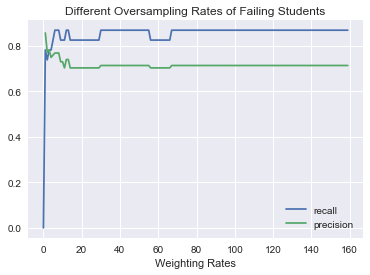

In [58]:
plt.plot(plotdata["weight"], plotdata["recall"])
plt.plot(plotdata["weight"], plotdata["precision"])
plt.title("Different Oversampling Rates of Failing Students")
plt.xlabel("Weighting Rates")
plt.legend()
plt.show()